In [14]:
# Import geojson file into geopandas dataframe and remove streets with no rating
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

traf_vol = gpd.read_file('../data/external/TDV_Shapefile_AADT_2014/AADT_2014.shp')
traf_vol = traf_vol[['AADT', 'geometry']]
traf_vol = traf_vol[traf_vol.AADT != 'null' ]
traf_vol.head()

IOError: no such file or directory: '../data/external/TDV_Shapefile_AADT_2014/AADT_2014.shp'

In [ ]:
# Check crs
traf_vol.crs

In [5]:
# Import boundary shapes for boroughs
nyc_bdry = gpd.read_file('../data/external/nyc-boroughs/nybb_16c/nybb.shp')
nyc_bdry = nyc_bdry.to_crs({'init': 'epsg:26918'})
nyc_bdry

,BoroCode,BoroName,Shape_Area,Shape_Leng,geometry
0,5,Staten Island,1.623819e+09,330476.026530,(POLYGON ((580375.2841426728 4491060.736975832...
1,2,Bronx,1.186816e+09,463934.696838,(POLYGON ((593066.6583069382 4516675.697967442...
2,1,Manhattan,6.364539e+08,358410.672987,(POLYGON ((583578.4583573071 4504203.877192213...
3,3,Brooklyn,1.937474e+09,741074.709979,(POLYGON ((595882.1112212382 4492983.277103473...
4,4,Queens,3.044835e+09,895762.746967,(POLYGON ((598434.3019409842 4494444.181008735...


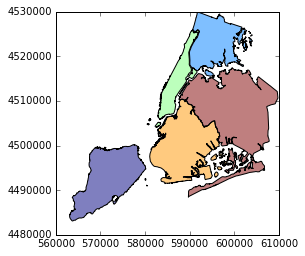

In [7]:
# Plot borough boundaries
nyc_bdry.plot()

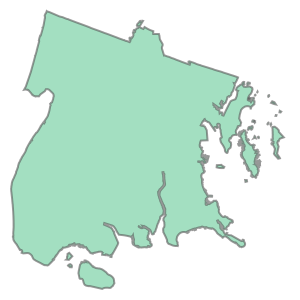

In [11]:
# Plot manhattan boundary
nyc_bdry_manh = nyc_bdry.ix[1].geometry
nyc_bdry_manh

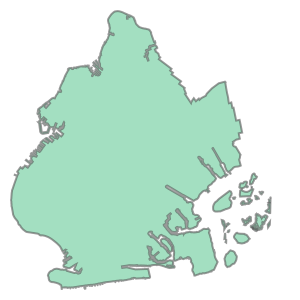

In [12]:
# Plot brooklyn boundary
nyc_bdry_bk = nyc_bdry.ix[3].geometry
nyc_bdry_bk

In [13]:
# Create Manhattan traffic volume dataframe
nyc_traf_vol_manh = traf_vol[traf_vol.geometry.within(nyc_bdry_manh)]
nyc_traf_vol_manh.head()

NameError: name 'traf_vol' is not defined

In [10]:
# Create Brooklyn traffic volume dataframe
nyc_traf_vol_bk = traf_vol[traf_vol.geometry.within(nyc_bdry_bk)]
nyc_traf_vol_bk.head()

,AADT,geometry
1059,26263,LINESTRING Z (591457.04 4498472.98 1.090886875...
1060,23203,LINESTRING Z (591593.449981722 4496965.8888635...
1061,13826,LINESTRING Z (587015.2799999993 4502926.59 -1....
1062,8536,LINESTRING Z (586465.0468953541 4501487.351156...
1063,5740,LINESTRING Z (581641.1200000001 4496069.260000...


In [9]:
# Import citibike station csv into geopandas dataframe
from shapely.geometry import Point

stations = pd.read_csv('../data/processed/stations.csv')

geometry = gpd.GeoSeries([Point(xy) for xy in zip(stations.Longitude, stations.Latitude)])
geometry = geometry.buffer(.0005)
geo_stations = gpd.GeoDataFrame(stations, geometry=geometry)
geo_stations.crs = {'init' :'epsg:4326'}
geo_stations.head()

,Station_id,Station_Name,Location,Latitude,Longitude,geometry
0,72,W 52 St & 11 Ave,W 52 St & 11 Ave,40.767272,-73.993929,"POLYGON ((-73.99342888 40.76727216, -73.993431..."
1,79,Franklin St & W Broadway,Franklin St & W Broadway,40.719116,-74.006667,"POLYGON ((-74.00616660999999 40.71911552, -74...."
2,82,St James Pl & Pearl St,St James Pl & Pearl St,40.711174,-74.000165,"POLYGON ((-73.99966544999999 40.71117416, -73...."
3,83,Atlantic Ave & Fort Greene Pl,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,"POLYGON ((-73.97582328 40.68382604, -73.975825..."
4,116,W 17 St & 8 Ave,W 17 St & 8 Ave,40.741776,-74.001497,"POLYGON ((-74.00099745999999 40.74177603, -74...."


In [11]:
len(geo_stations)

664

In [14]:
# Merge street quality data with citibike stations using Geopandas Spatial Merge
stations_traf_vol_manh = gpd.sjoin(geo_stations, nyc_traf_vol_manh, how="inner", op='intersects')
stations_traf_vol_manh.drop(['index_right', 'Location', 'geometry', 'Latitude', 'Longitude', 'Station_Name'], axis=1, inplace=True)
stations_traf_vol_manh.sort_index(inplace=True)
stations_traf_vol_manh.AADT = pd.to_numeric(stations_traf_vol_manh.AADT)
stations_traf_vol_manh.head(10)

,Station_id,AADT
0,72,5881
0,72,23604
1,79,22198
1,79,1739
2,82,12470
2,82,21288
4,116,7845
4,116,24030
7,127,11376
8,128,32554


In [15]:
# Find average of street quality ratings for each station
stations_traf_vol_manh = stations_traf_vol_manh.groupby(['Station_id']).mean()
stations_traf_vol_manh.reset_index(inplace=True)
stations_traf_vol_manh.head()

,Station_id,AADT
0,72,14742.5
1,79,11968.5
2,82,16879.0
3,116,15937.5
4,127,11376.0


In [17]:
len(stations_traf_vol_manh)

301

In [19]:
# Merge street quality data with citibike stations using Geopandas Spatial Merge
stations_traf_vol_bk = gpd.sjoin(geo_stations, nyc_traf_vol_bk, how="inner", op='intersects')
stations_traf_vol_bk.drop(['index_right', 'Location', 'geometry', 'Latitude', 'Longitude', 'Station_Name'], axis=1, inplace=True)
stations_traf_vol_bk.sort_index(inplace=True)
stations_traf_vol_bk.AADT = pd.to_numeric(stations_traf_vol_bk.AADT)
stations_traf_vol_bk.head(10)

,Station_id,AADT
3,83,37706
3,83,26223
5,119,10248
5,119,115359
6,120,6942
10,143,2976
10,143,14480
10,143,2190
10,143,6187
11,144,4316


In [20]:
# Find average of street quality ratings for each station
stations_traf_vol_bk = stations_traf_vol_bk.groupby(['Station_id']).mean()
stations_traf_vol_bk.reset_index(inplace=True)
stations_traf_vol_bk.head()

,Station_id,AADT
0,83,31964.50
1,119,62803.50
2,120,6942.00
3,143,6458.25
4,144,4316.00


In [21]:
len(stations_traf_vol_bk)

193

In [36]:
stations_traf_vol = stations_traf_vol_manh.append(stations_traf_vol_bk)
stations_traf_vol.sort_values('Station_id', inplace=True)
stations_traf_vol.reset_index(inplace=True)
stations_traf_vol.head()

,index,Station_id,AADT
0,0,72,14742.5
1,1,79,11968.5
2,2,82,16879.0
3,0,83,31964.5
4,3,116,15937.5
